# Machine Learning Algorithms Comparitive Analysis for prediction of Diabetes


### Importing Libraries


In [71]:
import os

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [72]:
# Importing Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import unittest

### Importing Dataset


In [73]:
dir_path = os.getcwd()

# Load the CSV file
df = pd.read_csv(os.path.join(dir_path, "../../Dataset/balanced_diabetes_data.csv"))
df.head()

Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     class  
0              No              Yes      Yes     Yes  Positive  
1             Yes               No      Yes      No  Positive  
2              No              Yes      Yes      No  Positive  
3              No               No       No      No  Positive  
4             Yes              Yes      Yes     Yes  Positive

In [74]:
# Checking for null values
df.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [75]:
# Checking for data types
df.info()

# Coverting columns to lower case
df.columns = map(str.lower, df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 1022 non-null   int64 
 1   Gender              1022 non-null   object
 2   Polyuria            1022 non-null   object
 3   Polydipsia          1022 non-null   object
 4   sudden weight loss  1022 non-null   object
 5   weakness            1022 non-null   object
 6   Polyphagia          1022 non-null   object
 7   Genital thrush      1022 non-null   object
 8   visual blurring     1022 non-null   object
 9   Itching             1022 non-null   object
 10  Irritability        1022 non-null   object
 11  delayed healing     1022 non-null   object
 12  partial paresis     1022 non-null   object
 13  muscle stiffness    1022 non-null   object
 14  Alopecia            1022 non-null   object
 15  Obesity             1022 non-null   object
 16  class               1022

In [76]:
duplicates = df.duplicated()
duplicates.sum()

df[df.duplicated()]

df = df.drop_duplicates()

### Data Visualization


In [77]:
# Create a new figure and axes for the subplots
figure, subplot_axes = plt.subplots(1, 2, figsize=(14, 7))

# Compute the counts of each class
class_counts = df["class"].value_counts()

# Define the color palette and explode parameters
color_palette_pie = sns.color_palette("muted6", 2)
explode_params = [0.05, 0.05]

# Create a pie chart on the first subplot with the new color palette
pie_chart = subplot_axes[0].pie(
    class_counts,
    autopct="%1.1f%%",
    startangle=90,
    labels=None,
    colors=color_palette_pie,
    explode=explode_params,
    shadow=True,
    wedgeprops={"linewidth": 1, "edgecolor": "k"},
)
subplot_axes[0].set_title("Target Distribution")
subplot_axes[0].legend(pie_chart[0], ["Positive", "Negative"], title="Class")

# Create a bar plot on the second subplot with a different color
class_counts.plot(kind="barh", ax=subplot_axes[1], color="lightblue", legend=False)
for idx, val in enumerate(class_counts.values):
    subplot_axes[1].text(val * 0.7, idx, str(val), weight="bold", fontsize=20)
subplot_axes[1].set_title("Class Distribution")
subplot_axes[1].set_xlabel("Count")
subplot_axes[1].set_ylabel("Class")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [78]:
# Diabetes distribution by age
plt.figure(figsize=(8, 6))
sns.histplot(df["age"], bins=30, color="royalblue", kde=True)
plt.title("Diabetes distribution by age", fontsize=16)

Text(0.5, 1.0, 'Diabetes distribution by age')

In [79]:
# Diabetes distribution by gender
plt.title("Diabetes cases by Gender", fontsize=17)
sns.countplot(x="gender", hue="class", data=df, palette=["#ff8080", "#78ebdc"])

/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: title={'center': 'Diabetes cases by Gender'}, xlabel='gender', ylabel='count'>

In [80]:
# Bar plots for symptoms and diabetes cases
count = 1
plt.figure(figsize=(15, 20))
plt.suptitle("Correlation between Symptoms and Diabetes Cases" + "\n", fontsize=20)
for i in df.columns:
    if i not in ["class", "age", "gender"]:
        plt.subplot(5, 4, count)
        plt.title(f"{i.title()}", fontweight="bold", fontsize=14)
        count += 1
        plt.tight_layout()
        total_count = df[i].value_counts()
        total_percentage = total_count / total_count.sum() * 100
        total_percentage.plot(kind="bar", color=["royalblue", "lightblue"])
        plt.ylabel("Count")
        plt.title(f"{i.title()}", fontweight="bold", fontsize=12)
        for j, v in enumerate(total_percentage):
            plt.text(j, v, f"{v:.1f}%", ha="center", va="bottom", fontweight="bold")
plt.show()

In [81]:
# Create a copy of the original DataFrame
df_copy = df.copy()

# Changing positive to 1 and negative to 0
df_copy["class"] = df_copy["class"].replace({"Positive": 1, "Negative": 0})

# Filter the DataFrame to only include rows where 'class' is 1
df_copy = df_copy[df_copy["class"] == 1]

# Label Encoding for object to numeric transformation
df_copy_encoder = preprocessing.LabelEncoder()

for col in df_copy.columns:
    if df_copy[col].dtype == "object":
        df_copy[col] = df_copy_encoder.fit_transform(df_copy[col])

# binary_cols is a list of binary columns, excluding 'class' and 'gender'
binary_cols = [
    col
    for col in df_copy.columns
    if df_copy[col].nunique() == 2 and col != "class" and col != "gender"
]

# Calculate the percentage of presence for each symptom
presence_percentages = df_copy[binary_cols].sum() / len(df_copy) * 100

# Calculate the percentage of absence for each symptom
absence_percentages = 100 - presence_percentages

# Create a DataFrame with presence and absence percentages
percentage_df = pd.DataFrame(
    {
        "Symptom Presence (%)": presence_percentages,
        "Symptom Absence (%)": absence_percentages,
    }
)

# Round the percentages to 2 decimal places
percentage_df = percentage_df.round(2)

# Sort the DataFrame in descending order by the presence percentages
percentage_df = percentage_df.sort_values(by="Symptom Presence (%)", ascending=False)

print("People with Positive Diabetes Diagnosis\n")
print(percentage_df)

People with Positive Diabetes Diagnosis

                    Symptom Presence (%)  Symptom Absence (%)
polyuria                           74.93                25.07
polydipsia                         70.57                29.43
weakness                           69.21                30.79
partial paresis                    58.04                41.96
polyphagia                         57.77                42.23
sudden weight loss                 57.49                42.51
visual blurring                    55.31                44.69
delayed healing                    52.04                47.96
itching                            48.23                51.77
muscle stiffness                   43.05                56.95
irritability                       35.15                64.85
genital thrush                     29.16                70.84
alopecia                           26.16                73.84
obesity                            18.53                81.47


/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_12038/120764218.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy["class"] = df_copy["class"].replace({"Positive": 1, "Negative": 0})


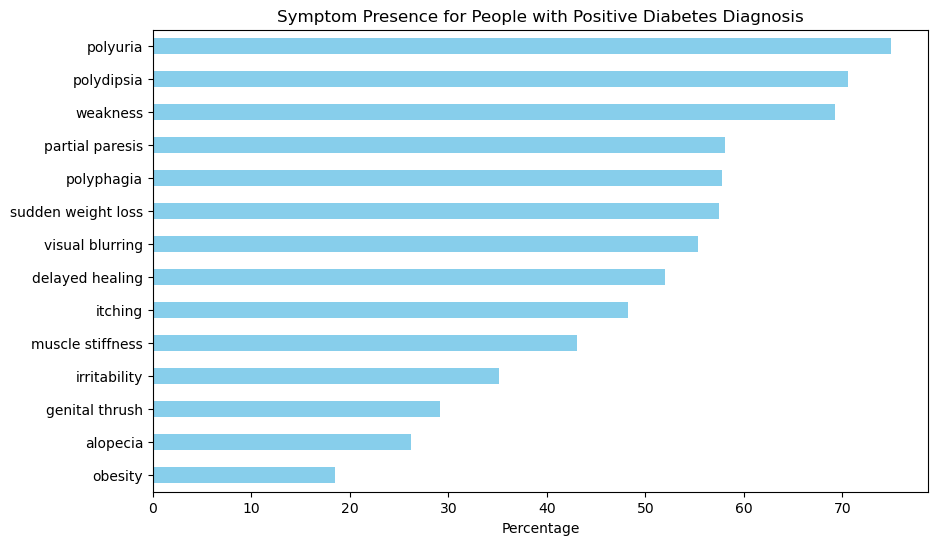

In [82]:
# Create a bar plot for the presence percentages
plt.figure(figsize=(10, 6))
percentage_df["Symptom Presence (%)"].sort_values().plot(kind="barh", color="skyblue")
plt.xlabel("Percentage")
plt.title("Symptom Presence for People with Positive Diabetes Diagnosis")
plt.show()

In [83]:
# Create a copy of the original DataFrame
df_copy_negative = df.copy()

# Changing positive to 1 and negative to 0
df_copy_negative["class"] = df_copy_negative["class"].replace(
    {"Positive": 1, "Negative": 0}
)

# Filter the DataFrame to only include rows where 'class' is 0
df_copy_negative = df_copy_negative[df_copy_negative["class"] == 0]

# Label Encoding for object to numeric transformation
df_copy_encoder = preprocessing.LabelEncoder()

for col in df_copy_negative.columns:
    if df_copy_negative[col].dtype == "object":
        df_copy_negative[col] = df_copy_encoder.fit_transform(df_copy_negative[col])

# binary_cols is a list of binary columns, excluding 'class' and 'gender'
binary_cols = [
    col
    for col in df_copy_negative.columns
    if df_copy_negative[col].nunique() == 2 and col != "class" and col != "gender"
]

# Calculate the percentage of presence for each symptom
presence_percentages_negative = (
    df_copy_negative[binary_cols].sum() / len(df_copy_negative) * 100
)

# Calculate the percentage of absence for each symptom
absence_percentages_negative = 100 - presence_percentages_negative

# Create a DataFrame with presence and absence percentages
percentage_df_negative = pd.DataFrame(
    {
        "Symptom Presence (%)": presence_percentages_negative,
        "Symptom Absence (%)": absence_percentages_negative,
    }
)

# Round the percentages to 2 decimal places
percentage_df_negative = percentage_df_negative.round(2)

# Sort the DataFrame in descending order by the presence percentages
percentage_df_negative = percentage_df_negative.sort_values(
    by="Symptom Presence (%)", ascending=False
)

print("People with Negative Diabetes Diagnosis\n")
print(percentage_df_negative)

People with Negative Diabetes Diagnosis

                    Symptom Presence (%)  Symptom Absence (%)
alopecia                           51.31                48.69
itching                            50.79                49.21
weakness                           49.48                50.52
delayed healing                    40.05                59.95
visual blurring                    30.89                69.11
muscle stiffness                   30.89                69.11
polyphagia                         26.18                73.82
genital thrush                     19.90                80.10
sudden weight loss                 16.75                83.25
partial paresis                    15.71                84.29
obesity                            12.83                87.17
polyuria                            8.12                91.88
irritability                        7.07                92.93
polydipsia                          3.93                96.07


/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_12038/3361258679.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy_negative["class"] = df_copy_negative["class"].replace(


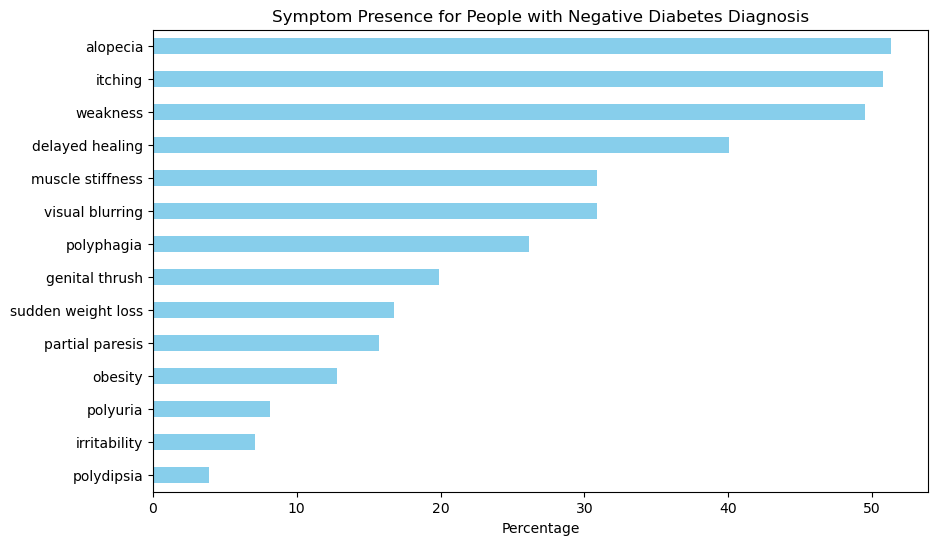

In [84]:
# Create a bar plot for the presence percentages
plt.figure(figsize=(10, 6))
percentage_df_negative["Symptom Presence (%)"].sort_values().plot(
    kind="barh", color="skyblue"
)
plt.xlabel("Percentage")
plt.title("Symptom Presence for People with Negative Diabetes Diagnosis")
plt.show()

### Data Preprocessing


In [85]:
# Changing positive to 1 and negative to 0
df["class"] = df["class"].replace({"Positive": 1, "Negative": 0})

# Seperating target feature from dataset
X = df.drop("class", axis=1)
y = df["class"]

# Storing features to list
objectList = X.select_dtypes(include="object").columns.tolist()
print(objectList)

['gender', 'polyuria', 'polydipsia', 'sudden weight loss', 'weakness', 'polyphagia', 'genital thrush', 'visual blurring', 'itching', 'irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'alopecia', 'obesity']


/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_12038/1584962235.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["class"] = df["class"].replace({"Positive": 1, "Negative": 0})


In [86]:
# Label Encoding for object to numeric transformation
encoder = preprocessing.LabelEncoder()

for col in X.columns:
    if X[col].dtype == "object":
        X[col] = encoder.fit_transform(X[col])

# Printing datatypes of features
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 0 to 1021
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 749 non-null    int64
 1   gender              749 non-null    int64
 2   polyuria            749 non-null    int64
 3   polydipsia          749 non-null    int64
 4   sudden weight loss  749 non-null    int64
 5   weakness            749 non-null    int64
 6   polyphagia          749 non-null    int64
 7   genital thrush      749 non-null    int64
 8   visual blurring     749 non-null    int64
 9   itching             749 non-null    int64
 10  irritability        749 non-null    int64
 11  delayed healing     749 non-null    int64
 12  partial paresis     749 non-null    int64
 13  muscle stiffness    749 non-null    int64
 14  alopecia            749 non-null    int64
 15  obesity             749 non-null    int64
dtypes: int64(16)
memory usage: 99.5 KB


In [87]:
# Printing first 5 rows of dataset
X.head()

age  gender  polyuria  polydipsia  sudden weight loss  weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   

   polyphagia  genital thrush  visual blurring  itching  irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   

   delayed healing  partial paresis  muscle stiffness  alopecia  obesity  
0                1                0                 1         1        1  
1                0                1                 0         1        0  
2                1                0                 1         1        0  
3                1                0                 0         0        0  
4                1                1                 1         1        1

In [88]:
# Compute the correlation matrix
corr_matrix = X.corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    ax=ax,
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [89]:
# Correlation between features and diabetes
X.corrwith(y).plot(
    kind="bar", grid=True, figsize=(8, 4), title="Correlation with Diabetes"
)

<Axes: title={'center': 'Correlation with Diabetes'}>

In [90]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (599, 16) (599,)
Testing set shape: (150, 16) (150,)


### Data Normalization


In [91]:
minmax = MinMaxScaler()
X_train[["age"]] = minmax.fit_transform(X_train[["age"]])
X_test[["age"]] = minmax.transform(X_test[["age"]])
X_train.head()

age  gender  polyuria  polydipsia  sudden weight loss  weakness  \
113  0.830769       1         0           1                   1         1   
763  0.353846       0         0           1                   0         0   
836  0.200000       0         0           0                   0         0   
16   0.446154       1         1           1                   1         1   
13   0.553846       1         1           1                   1         1   

     polyphagia  genital thrush  visual blurring  itching  irritability  \
113           1               1                0        1             1   
763           0               0                1        0             1   
836           0               0                0        0             0   
16            0               1                0        0             0   
13            1               1                1        1             0   

     delayed healing  partial paresis  muscle stiffness  alopecia  obesity  
113                0                1                 0         0        0  
763                1                0                 0         1        0  
836                1                0                 0         0        0  
16                 1                0                 1         0        0  
13                 0                0                 0         1        1

### Model Building


##### Logistic Regression


In [92]:
lg = LogisticRegression(random_state=0, penalty="l2")
lg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [93]:
# Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
score = "accuracy"

acc_lg = model_selection.cross_val_score(lg, X_train, y_train, cv=kfold, scoring=score)
acc_lg.mean()

0.9065536723163843

In [94]:
# Evaluation Metrics
y_pred_lg = lg.predict(X_test)

lg_acc = accuracy_score(y_test, y_pred_lg)
lg_roc = roc_auc_score(y_test, y_pred_lg)
lg_prec = precision_score(y_test, y_pred_lg)
lg_rec = recall_score(y_test, y_pred_lg)
lg_f1 = f1_score(y_test, y_pred_lg)

results_lg = pd.DataFrame(
    [["Logistic Regression", lg_acc, acc_lg.mean(), lg_roc, lg_prec, lg_rec, lg_f1]],
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ],
)

results_lg

Model  Accuracy  Cross Val Accuracy       ROC  Precision  \
0  Logistic Regression  0.933333            0.906554  0.930357    0.96875   

     Recall  F1 Score  
0  0.885714  0.925373

##### Decision Trees Classifier


In [95]:
dt = DecisionTreeClassifier(criterion="gini", random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [96]:
# Cross Validation
acc_dt = model_selection.cross_val_score(dt, X_train, y_train, cv=kfold, scoring=score)
acc_dt.mean()

0.8446892655367231

In [97]:
# Evaluation Metrics
y_pred_dt = dt.predict(X_test)

dt_acc = accuracy_score(y_test, y_pred_dt)
dt_roc = roc_auc_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt)
dt_rec = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

results_dt = pd.DataFrame(
    [
        [
            "Decision Trees Classifier",
            dt_acc,
            acc_dt.mean(),
            dt_roc,
            dt_prec,
            dt_rec,
            dt_f1,
        ]
    ],
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ],
)

results_dt

Model  Accuracy  Cross Val Accuracy       ROC  \
0  Decision Trees Classifier      0.86            0.844689  0.860714   

   Precision    Recall  F1 Score  
0   0.835616  0.871429  0.853147

##### Random Forest Classifier


In [98]:
estimators = 100

for i in range(1, estimators):
    rf = RandomForestClassifier(n_estimators=i, criterion="entropy", random_state=0)
    rf.fit(X_train, y_train)

In [99]:
# Cross Validation
acc_rf = model_selection.cross_val_score(rf, X_train, y_train, cv=kfold, scoring=score)
acc_rf.mean()

0.9148587570621467

In [100]:
# Evaluation Metrics
y_pred_rf = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_roc = roc_auc_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

results_rf = pd.DataFrame(
    [
        [
            "Random Forest Classifier",
            rf_acc,
            acc_rf.mean(),
            rf_roc,
            rf_prec,
            rf_rec,
            rf_f1,
        ]
    ],
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ],
)

results_rf

Model  Accuracy  Cross Val Accuracy     ROC  Precision  \
0  Random Forest Classifier      0.94            0.914859  0.9375   0.969231   

   Recall  F1 Score  
0     0.9  0.933333

##### Neural Networks


In [101]:
def create_model():
    model = Sequential(
        [
            Dense(16, input_dim=16, activation="relu"),
            Dropout(0.5),
            Dense(8, activation="relu"),
            Dropout(0.5),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


nn = create_model()
nn.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

In [102]:
# Custom cross-validation
def custom_cross_val_score(model_func, X, y, n_splits=10):
    kfold = model_selection.StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=7
    )
    scores = []

    for train_ix, test_ix in kfold.split(X, y):
        model = clone_model(model_func())
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
        )
        X_train_fold, X_test_fold = X[train_ix], X[test_ix]
        y_train_fold, y_test_fold = y[train_ix], y[test_ix]
        model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=10, verbose=1)
        scores.append(model.evaluate(X_test_fold, y_test_fold, verbose=0)[1])

    return np.mean(scores)


acc_nn = custom_cross_val_score(create_model, X_train.values, y_train.values)

Epoch 1/100
54/54 [==============================] - 0s 674us/step - loss: 0.7208 - accuracy: 0.5158
Epoch 2/100
54/54 [==============================] - 0s 588us/step - loss: 0.6782 - accuracy: 0.5807
Epoch 3/100
54/54 [==============================] - 0s 518us/step - loss: 0.6454 - accuracy: 0.5881
Epoch 4/100
54/54 [==============================] - 0s 529us/step - loss: 0.6226 - accuracy: 0.6160
Epoch 5/100
54/54 [==============================] - 0s 520us/step - loss: 0.6141 - accuracy: 0.6401
Epoch 6/100
54/54 [==============================] - 0s 509us/step - loss: 0.5656 - accuracy: 0.6772
Epoch 7/100
54/54 [==============================] - 0s 517us/step - loss: 0.5892 - accuracy: 0.6494
Epoch 8/100
54/54 [==============================] - 0s 510us/step - loss: 0.5430 - accuracy: 0.6790
Epoch 9/100
54/54 [==============================] - 0s 510us/step - loss: 0.5195 - accuracy: 0.7236
Epoch 10/100
54/54 [==============================] - 0s 506us/step - loss: 0.4687 - accura

In [103]:
# Evaluation Metrics
y_pred_nn = nn.predict(X_test).ravel()
y_pred_nn_classes = (y_pred_nn > 0.5).astype(int)

nn_acc = accuracy_score(y_test, y_pred_nn_classes)
nn_roc = roc_auc_score(y_test, y_pred_nn)
nn_prec = precision_score(y_test, y_pred_nn_classes)
nn_rec = recall_score(y_test, y_pred_nn_classes)
nn_f1 = f1_score(y_test, y_pred_nn_classes)

results_nn = pd.DataFrame(
    [["Neural Network", nn_acc, acc_nn, nn_roc, nn_prec, nn_rec, nn_f1]],
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ],
)

results_nn

5/5 [==============================] - 0s 774us/step


Model  Accuracy  Cross Val Accuracy       ROC  Precision  \
0  Neural Network      0.92            0.903192  0.967857   0.939394   

     Recall  F1 Score  
0  0.885714  0.911765

##### K-Nearest Neighbor


In [104]:
knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [105]:
# Cross Validation
acc_knn = model_selection.cross_val_score(
    knn, X_train, y_train, cv=kfold, scoring=score
)
acc_knn.mean()

0.8815254237288135

In [106]:
# Evaluation Metrics
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_roc = roc_auc_score(y_test, y_pred_knn)
knn_prec = precision_score(y_test, y_pred_knn)
knn_rec = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

results_knn = pd.DataFrame(
    [
        [
            "K-Nearest Neighbors",
            knn_acc,
            acc_knn.mean(),
            knn_roc,
            knn_prec,
            knn_rec,
            knn_f1,
        ]
    ],
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ],
)

results_knn

Model  Accuracy  Cross Val Accuracy       ROC  Precision  \
0  K-Nearest Neighbors  0.886667            0.881525  0.883036   0.920635   

     Recall  F1 Score  
0  0.828571   0.87218

/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_12038/1691996111.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat(


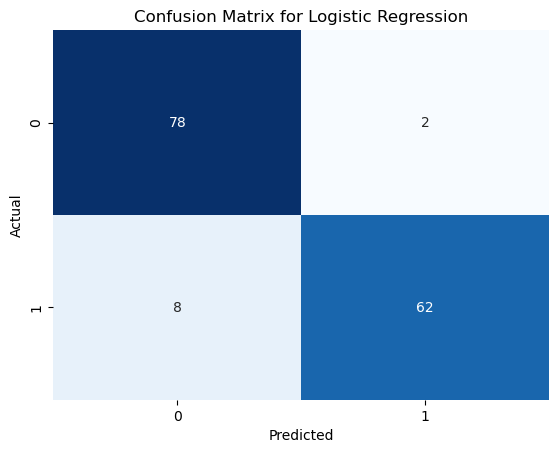

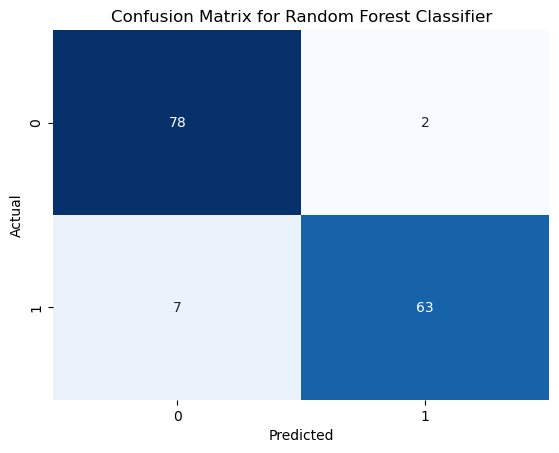

5/5 [==============================] - 0s 767us/step


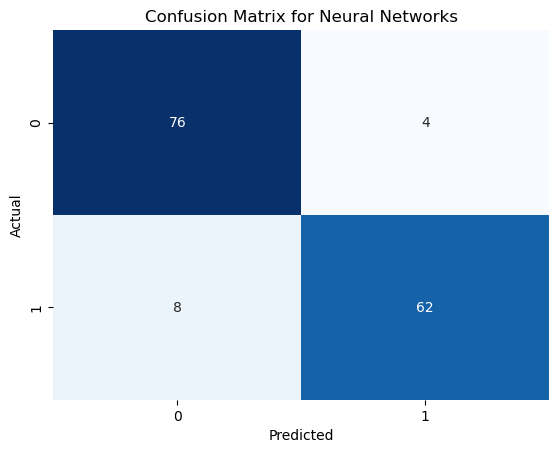

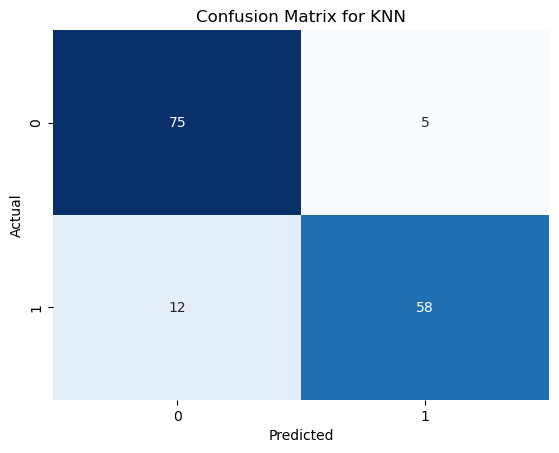

Model   Accuracy  Cross Val Accuracy        ROC  \
0        Logistic Regression  93.333333           93.333333  93.035714   
1  Decision Trees Classifier  86.000000           86.000000  86.071429   
2   Random Forest Classifier  94.000000           94.000000  93.750000   
3            Neural Networks  92.000000           92.000000  91.785714   
4                        KNN  88.666667           88.666667  88.303571   

   Precision     Recall   F1 Score  
0  96.875000  88.571429  92.537313  
1  83.561644  87.142857  85.314685  
2  96.923077  90.000000  93.333333  
3  93.939394  88.571429  91.176471  
4  92.063492  82.857143  87.218045

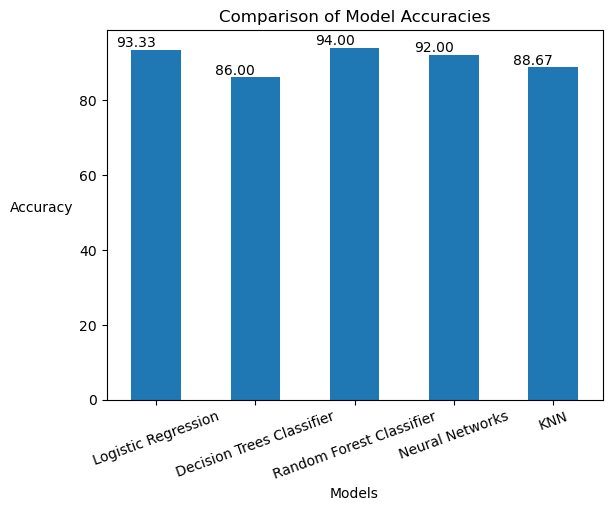

In [107]:
# Initialize a DataFrame to store the results
final_results = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Cross Val Accuracy",
        "ROC",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# List of models and their names
models = [lg, dt, rf, nn, knn]
model_names = [
    "Logistic Regression",
    "Decision Trees Classifier",
    "Random Forest Classifier",
    "Neural Networks",
    "KNN",
]

for model, name in zip(models, model_names):
    # Predict the test set results
    y_pred = model.predict(X_test)

    if name == "Neural Networks":
        y_pred = (y_pred > 0.5).astype(int)

    # Calculate the evaluation metrics
    acc = accuracy_score(y_test, y_pred) * 100
    roc = roc_auc_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    # Append the results to the DataFrame
    final_results = pd.concat(
        [
            final_results,
            pd.DataFrame(
                {
                    "Model": [name],
                    "Accuracy": [acc],
                    "Cross Val Accuracy": [acc.mean()],
                    "ROC": [roc],
                    "Precision": [prec],
                    "Recall": [rec],
                    "F1 Score": [f1],
                }
            ),
        ],
        ignore_index=True,
    )

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

final_results.plot(
    x="Model",
    y="Accuracy",
    kind="bar",
    title="Comparison of Model Accuracies",
    xlabel="Models",
    rot=20,
)
plt.ylabel("Accuracy", rotation=0, ha="right")
plt.gca().get_legend().remove()

# Add percentage labels to the bars
for i, v in enumerate(final_results["Accuracy"]):
    plt.text(i, v, f"{v:.2f}", ha="right", va="bottom")

# Print the final results
final_results

In [108]:
class TestModels(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        cls.test_data = pd.read_csv("../../Dataset/TestingDiabetes-Dataset.csv")
        cls.test_data.columns = cls.test_data.columns.str.lower()

        # Label Encoding for object to numeric transformation
        encoder = preprocessing.LabelEncoder()
        for col in cls.test_data.columns:
            if cls.test_data[col].dtype == "object":
                cls.test_data[col] = encoder.fit_transform(cls.test_data[col])

        # Normalize 'age' feature
        scaler = MinMaxScaler()
        cls.test_data[["age"]] = scaler.fit_transform(cls.test_data[["age"]])

        cls.X_test = cls.test_data.drop("class", axis=1)
        cls.y_test = cls.test_data["class"]

    def test_logistic_regression(self):
        y_pred = lg.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred) * 100
        self.assertTrue(70 <= acc <= 100)
        print(pd.DataFrame({"Model": ["Logistic Regression"], "Accuracy": [acc]}))
        print("Prediction Results:")
        print(pd.DataFrame({"Actual": self.y_test, "Predicted": y_pred}))

    def test_decision_tree(self):
        y_pred = dt.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred) * 100
        self.assertTrue(70 <= acc <= 100)
        print(pd.DataFrame({"Model": ["Decision Tree"], "Accuracy": [acc]}))
        print("Prediction Results:")
        print(pd.DataFrame({"Actual": self.y_test, "Predicted": y_pred}))

    def test_random_forest(self):
        y_pred = rf.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred) * 100
        self.assertTrue(70 <= acc <= 100)
        print(pd.DataFrame({"Model": ["Random Forest"], "Accuracy": [acc]}))
        print("Prediction Results:")
        print(pd.DataFrame({"Actual": self.y_test, "Predicted": y_pred}))

    def test_neural_network(self):
        y_pred = nn.predict(self.X_test)
        y_pred = (y_pred > 0.5).astype(int)
        y_pred = y_pred.flatten()
        acc = accuracy_score(self.y_test, y_pred) * 100
        self.assertTrue(70 <= acc <= 100)
        print(pd.DataFrame({"Model": ["Neural Network"], "Accuracy": [acc]}))
        print("Prediction Results:")
        print(pd.DataFrame({"Actual": self.y_test, "Predicted": y_pred}))

    def test_knn(self):
        y_pred = knn.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred) * 100
        self.assertTrue(70 <= acc <= 100)
        print(pd.DataFrame({"Model": ["K-Nearest Neighbors"], "Accuracy": [acc]}))
        print("Prediction Results:")
        print(pd.DataFrame({"Actual": self.y_test, "Predicted": y_pred}))


if __name__ == "__main__":
    unittest.main(argv=["first-arg-is-ignored"], exit=False)

...

           Model   Accuracy
0  Decision Tree  91.666667
Prediction Results:
    Actual  Predicted
0        1          0
1        1          1
2        1          1
3        1          1
4        1          1
5        1          1
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
                 Model   Accuracy
0  K-Nearest Neighbors  83.333333
Prediction Results:
    Actual  Predicted
0        1          0
1        1          1
2        1          0
3        1          1
4        1          1
5        1          1
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
                 Model  Accuracy
0  Logistic Regression      75.0
Prediction Results:
    Actual  Predicted
0        1          0
1        1          0
2        1          0
3        1          1
4        1          1
5        1          1
6        0          0
7 

..
----------------------------------------------------------------------
Ran 5 tests in 0.056s

OK


            Model  Accuracy
0  Neural Network      75.0
Prediction Results:
    Actual  Predicted
0        1          0
1        1          0
2        1          0
3        1          1
4        1          1
5        1          1
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
           Model  Accuracy
0  Random Forest     100.0
Prediction Results:
    Actual  Predicted
0        1          1
1        1          1
2        1          1
3        1          1
4        1          1
5        1          1
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
